In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
data = pd.read_excel("CocaCola_Sales_Rawdata.xlsx",header=0,index_col=0,parse_dates=True)
data

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996
Q2_87,2104.411995
Q3_87,2014.362999
Q4_87,1991.746998
Q1_88,1869.049999


<AxesSubplot:xlabel='Quarter'>

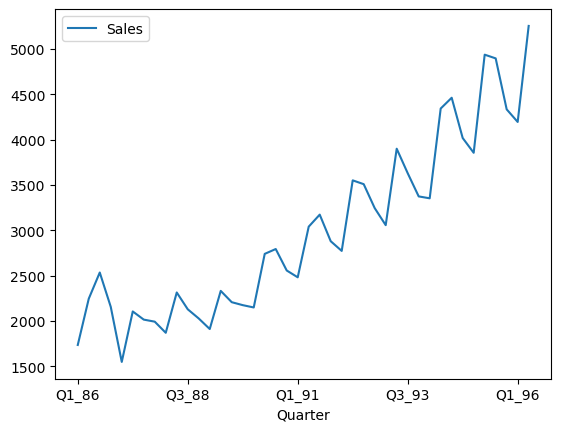

In [3]:
data.plot()

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

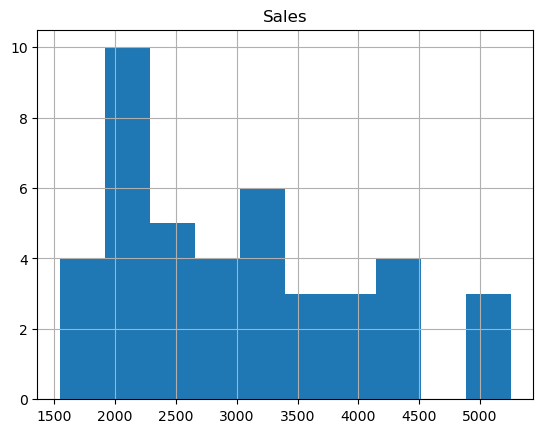

In [4]:
data.hist()

<AxesSubplot:ylabel='Density'>

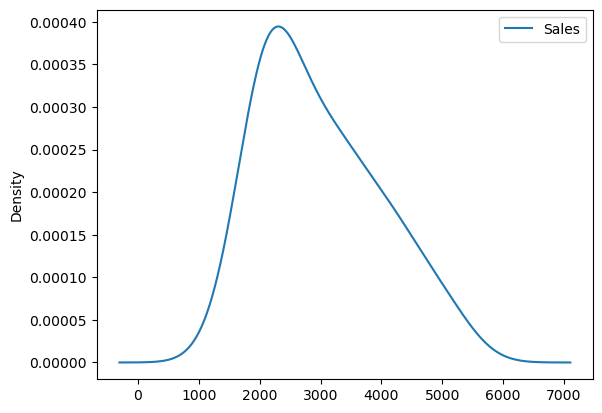

In [5]:
data.plot(kind='kde')

Sarima model

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

train = data.iloc[:32]
test = data.iloc[32:]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [36]:
import warnings
warnings.filterwarnings('ignore')
model = SARIMAX(train['Sales'], order=(1,1,1),seasonal_order=(1,1,1,12))
result = model.fit(disp=False)

forecast = result.get_forecast(steps=len(test))
predicted_values = forecast.predicted_mean

rmse_sarima = sqrt(mean_squared_error(test['Sales'], predicted_values))
print(f'Sarima RMSE: {rmse_sarima}')

Sarima RMSE: 601.3159807784705


Arima model

In [37]:
from statsmodels.tsa.arima.model import ARIMA


model_arima = ARIMA(train['Sales'], order=(1,1,1))
result_arima = model_arima.fit()


forecast_arima = result_arima.get_forecast(steps=len(test))
predicted_values_arima = forecast_arima.predicted_mean


rmse_arima = sqrt(mean_squared_error(test['Sales'], predicted_values_arima))
print(f'Arima RMSE: {rmse_arima}')

Arima RMSE: 1055.510806626102


# Data Driven model

Moving Average

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

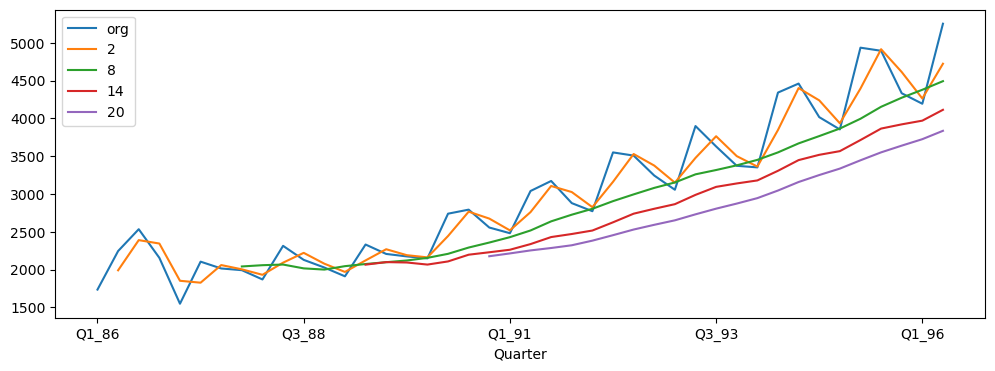

In [39]:
plt.figure(figsize=(12,4))
data.Sales.plot(label="org")
for i in range(2,24,6):
    data["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

Time series decomposition plot

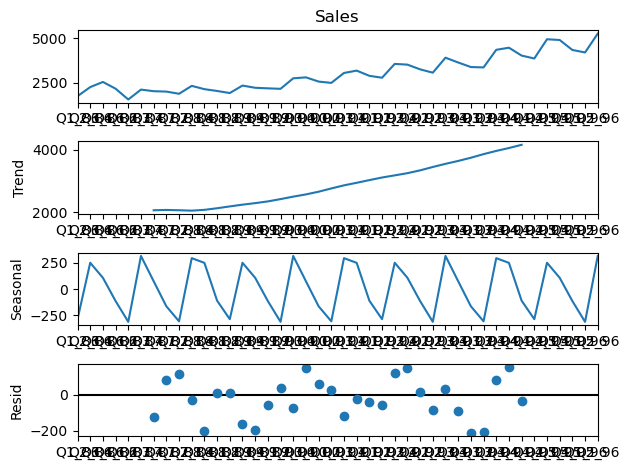

In [40]:
decompose_ts_add = seasonal_decompose(data.Sales,period=12)
decompose_ts_add.plot()
plt.show()

ACF plots and PACF plots

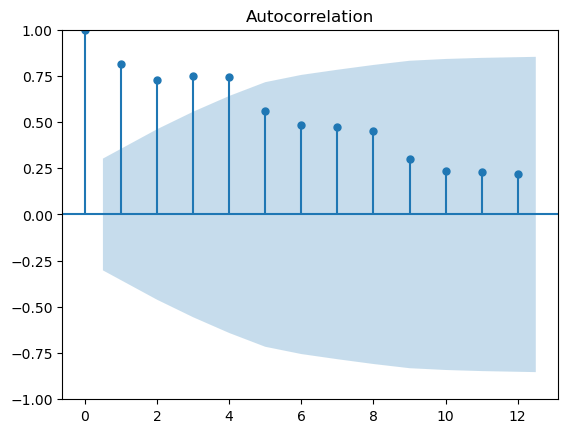

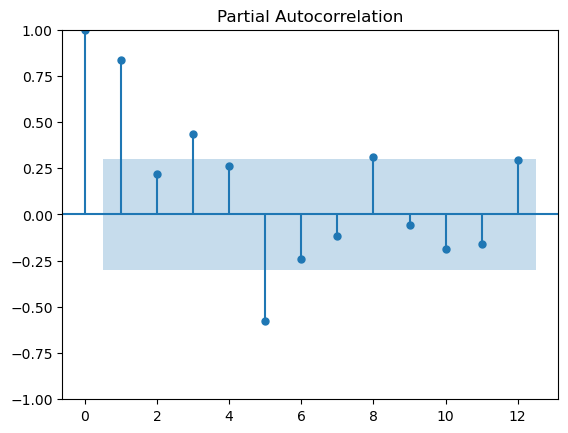

In [41]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Sales,lags=12)
tsa_plots.plot_pacf(data.Sales,lags=12)
plt.show()

Simple Exponential Method

In [43]:
train["Sales"] = train["Sales"].astype('double') 
ses_model = SimpleExpSmoothing(train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])


rmse_ses = sqrt(mean_squared_error(test['Sales'], pred_ses))
print(f'SimpleExpSmoothing RMSE: {rmse_ses}')

SimpleExpSmoothing RMSE: 2374.548418557267


Holt method

In [44]:
hw_model = Holt(train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])

rmse_holt = sqrt(mean_squared_error(test['Sales'], pred_hw))
print(f'Holt RMSE: {rmse_holt}')

Holt RMSE: 2409.323056012015


Holts winter exponential smoothing with additive seasonality and additive trend

In [45]:
hwe_model_add_add = ExponentialSmoothing(train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])


rmse_hwe_add_add = sqrt(mean_squared_error(test['Sales'], pred_hwe_add_add))
print(f'Holt winter add add  RMSE: {rmse_hwe_add_add}')

Holt winter add add  RMSE: 2311.1003424814658


Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [46]:
hwe_model_mul_add = ExponentialSmoothing(train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])


rmse_hwe_mul_add = sqrt(mean_squared_error(test['Sales'], pred_hwe_mul_add))
print(f'Holt winter mul add  RMSE: {rmse_hwe_mul_add}')

Holt winter mul add  RMSE: 2328.654278245551


In [48]:
rmse_values = {
    'ARIMA': rmse_arima,
    'SARIMA': rmse_sarima,
    'SES': rmse_ses,
    'Holt': rmse_holt,
    'Holt we_add_add': rmse_hwe_add_add,
    'Holt we_mul_add': rmse_hwe_mul_add
}

rmse_df = pd.DataFrame(list(rmse_values.items()), columns=['Model', 'RMSE'])
print(rmse_df)

             Model         RMSE
0            ARIMA  1055.510807
1           SARIMA   601.315981
2              SES  2374.548419
3             Holt  2409.323056
4  Holt we_add_add  2311.100342
5  Holt we_mul_add  2328.654278


# Sarima model has lowest RMSE value which is 601.31. so i will use Sarima model to forecast.

In [51]:
model = SARIMAX(data['Sales'], order=(1,1,1),seasonal_order=(1,1,1,12))
result = model.fit(disp=False)

result.forecast(10)


42    4936.945376
43    4668.392361
44    4638.111236
45    5632.903686
46    5740.457862
47    5296.163037
48    5128.133669
49    6205.757629
50    6151.407142
51    5596.465756
Name: predicted_mean, dtype: float64